# From Least Squares Benchmarks to the Marchenko–Pastur Distribution

This is the notebook accompanying blog post https://lorentzen.ch/index.php/2022/05/22/from-least-squares-benchmarks-to-the-marchenko-pastur-distribution/. It is inspired by the scipy issue https://github.com/scipy/scipy/issues/11204.

## 1. Benchmarking Least Squares

In [1]:
from collections import OrderedDict
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lstsq
from scipy.sparse.linalg import lsqr
import seaborn as sns
from neurtu import Benchmark, delayed

plt.ion()


p_list = [100, 500]
rng = np.random.default_rng(42)
X = rng.standard_normal(max(p_list) ** 2 * 2)
y = rng.standard_normal(max(p_list) * 2)


def bench_cases():    
    for p in p_list:
        for n in np.arange(0.1, 2.1, 0.1):
            n = int(p*n)
            A = X[:n*p].reshape(n, p)
            b = y[:n]
            for solver in ['lstsq', 'lsqr']:
                tags = OrderedDict(n=n, p=p, solver=solver)
                if solver == 'lstsq':
                    solve = delayed(lstsq, tags=tags)
                elif solver == 'lsqr':
                    solve = delayed(
                        partial(
                            lsqr, atol=1e-10, btol=1e-10, iter_lim=1e6
                        ),
                        tags=tags)

                yield solve(A, b)

In [2]:
bench = Benchmark(wall_time=True)
df = bench(bench_cases())

  0%|          | 0/80 [00:00<?, ?it/s]

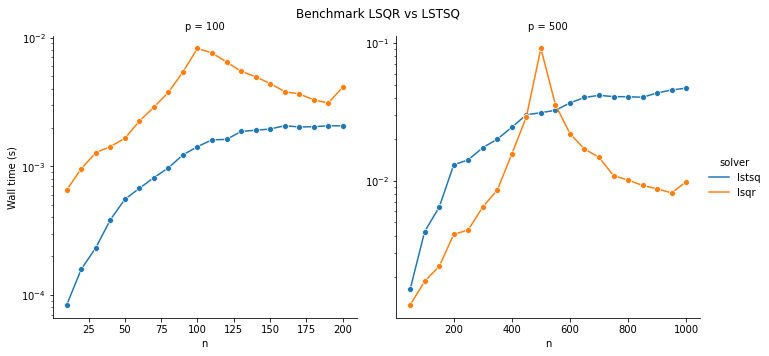

In [3]:
g = sns.relplot(x='n', y='wall_time', hue='solver', col='p',
            kind='line', facet_kws={'sharex': False, 'sharey': False},
            data=df.reset_index(), marker='o')
g.set_titles("p = {col_name}")
g.set_axis_labels("n", "Wall time (s)")
g.set(xscale="linear", yscale="log")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Benchmark LSQR vs LSTSQ')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

In [4]:
g.savefig("fig_benchmark.png", dpi=300)

## 2. The Marchenko Pastur Distribution

In [5]:
def marchenko_pastur_mu(x, rho, sigma2=1):
    x = np.atleast_1d(x).astype(float)
    rho_p = sigma2 * (1 + np.sqrt(rho)) ** 2
    rho_m = sigma2 * (1 - np.sqrt(rho)) ** 2
    mu = np.zeros_like(x)
    is_nonzero = (rho_m < x) & (x < rho_p)
    x_valid = x[is_nonzero]
    factor = 1 / (2 * np.pi * sigma2 * rho)
    mu[is_nonzero] = factor / x_valid
    mu[is_nonzero] *= np.sqrt((rho_p - x_valid) * (x_valid - rho_m))
    if rho > 1:
        mu[x == 0] = 1 - 1 / rho
    return mu

## 3. Empirical Confirmation of the Marchenko–Pastur Distribution

Text(0.5, 1.0, 'Empirical evidence for n=1000, p=500, rho=0.5')

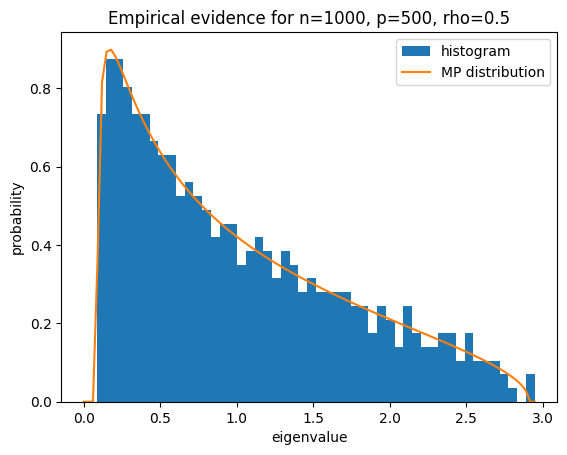

In [6]:
fig, ax = plt.subplots()

n, p = 1000, 500
A = X.reshape(n, p)
Y = 1/n * A.T @ A
eigenvals, _ = np.linalg.eig(Y)
ax.hist(eigenvals.real, bins=50, density=True, label="histogram")
x = np.linspace(0, np.max(eigenvals.real), 100)
ax.plot(x, marchenko_pastur_mu(x, rho=p/n), label="MP distribution")
ax.legend()
ax.set_xlabel("eigenvalue")
ax.set_ylabel("probability")
ax.set_title("Empirical evidence for n=1000, p=500, rho=0.5")

In [7]:
fig.savefig("empirical_eigenvalue_distribution.png", dpi=300)

Text(0.5, 1.0, 'Empirical evidence for n=500, p=1000, rho=2')

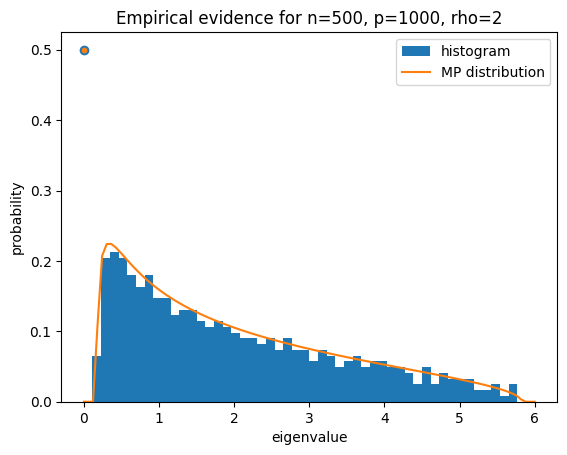

In [8]:
# Another one for rho > 1.
# This is tricky because the point mass needs special treatment
fig, ax = plt.subplots()

n, p = 500, 1000
bins = np.linspace(0, 6, 50)
step_size = bins[1] - bins[0]

A = X.reshape(n, p)
Y = 1/n * A.T @ A
eigenvals, _ = np.linalg.eig(Y)

n_zeros = np.sum(eigenvals.real < 1e-3)
weights = np.full_like(eigenvals.real, fill_value=1/p/step_size) 
weights[eigenvals.real < 1e-3] = 0  # do not count zeros
h_values, h_bins, h_bar = ax.hist(eigenvals.real, bins=50, weights=weights, label="histogram")
ax.scatter(0, n_zeros/p, color = h_bar[-1].get_facecolor())
x = np.linspace(1e-3, 6, 100)
line, = ax.plot(x, marchenko_pastur_mu(x, rho=p/n), label="MP distribution")
ax.scatter(0, marchenko_pastur_mu(0, rho=p/n), s=10, color = line.get_color())
ax.legend()
ax.set_xlabel("eigenvalue")
ax.set_ylabel("probability")
ax.set_title("Empirical evidence for n=500, p=1000, rho=2")

## 4. Conclusion

Text(0, 0.5, 'dmu/dx')

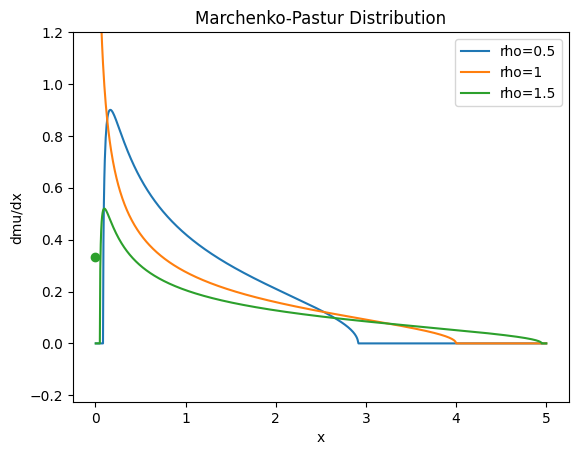

In [9]:
fig, ax = plt.subplots()

rho_list = [0.5, 1, 1.5]
x = np.linspace(0, 5, 1000)[1:] # exclude 0
for rho in rho_list:
    y = marchenko_pastur_mu(x, rho)
    line, = ax.plot(x, y, label=f"rho={rho}")
    # plot zero point mass
    if rho > 1:
        ax.scatter(0, marchenko_pastur_mu(0, rho), color = line.get_color())

ax.set_ylim(None, 1.2)
ax.legend()
ax.set_title("Marchenko-Pastur Distribution")
ax.set_xlabel("x")
ax.set_ylabel("dmu/dx")

In [10]:
fig.savefig("marchenko_pastur_distribution.png", dpi=300)

Text(0.5, 1.0, 'Condition Number of A for p=500')

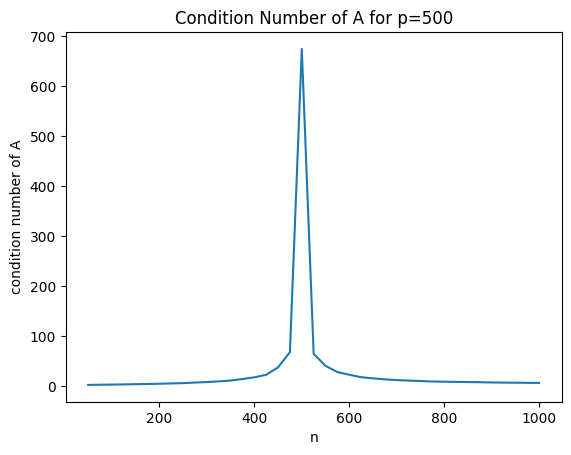

In [11]:
p = 500
n_vec = []
c_vec = []
for n in np.arange(0.1, 2.05, 0.05):
    n = int(p*n)
    A = X[:n*p].reshape(n, p)
    n_vec.append(n)
    c_vec.append(np.linalg.cond(A))

fig, ax = plt.subplots()
ax.plot(n_vec, c_vec)
ax.set_xlabel("n")
ax.set_ylabel("condition number of A")
ax.set_title("Condition Number of A for p=500")

In [12]:
fig.savefig("condition_number.png", dpi=300)